In [154]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
import cmocean
from datetime import datetime, timedelta, timezone
import urllib
import os.path
import string

%matplotlib inline

In [144]:
modis = xr.open_dataset("data/IMOS/MODIS/IMOS_aggregation_20220726T015142Z/IMOS_aggregation_20220726T015142Z.nc",  decode_times=False)

In [145]:
modis.sel(time=slice(9404+10, 9404+20))

<xarray.Dataset>
Dimensions:    (longitude: 2751, time: 10, latitude: 3015)
Coordinates:
  * longitude  (longitude) float64 141.4 141.4 141.4 141.4 ... 168.9 168.9 168.9
  * latitude   (latitude) float64 -18.92 -18.93 -18.94 ... -49.04 -49.05 -49.06
  * time       (time) float64 9.414e+03 9.415e+03 ... 9.422e+03 9.423e+03
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    source_path:          imos-srs/archive/oc/aqua/1d/v201909/2015/10/A201510...
    history:              File initialised at 2020-08-06T06:25:26.465197\nIni...
    Conventions:          CF-1.6
    time_coverage_start:  2015-10-01T05:30:00Z
    time_coverage_end:    2015-10-31T05:30:00Z
    title:                ${1}, 2015-10-01T05:30:00Z, 2015-10-31T05:30:00Z
    geospatial_lat_min:   -49.06
    geospatial_lat_max:   -18.92
    geospatial_lon_min:   141.4
    geospatial_lon_max:   168.9

In [146]:
# Mean of modis
# take mean over time
modis = modis.mean(dim="time", skipna=True)

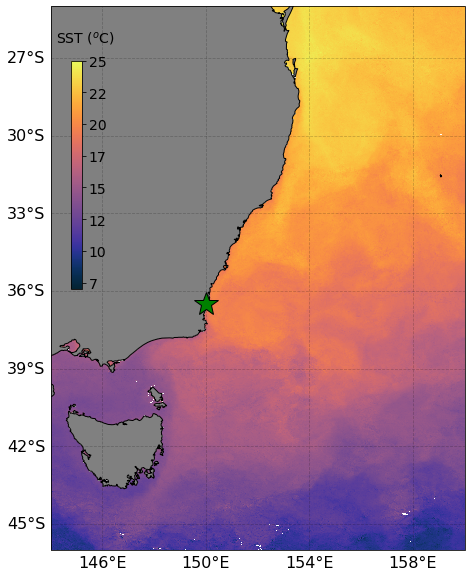

In [238]:
fig = plt.figure(figsize=(18,10))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())

#set coastline
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', 
                                     facecolor='none', name='coastline')
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im = modis.sst.plot.pcolormesh(cmap=cmocean.cm.thermal, add_colorbar=False,
                               vmin=7, vmax=25)
extent_ls = [144,160,-25,-46]
ax.set_extent(extent_ls)

# make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True, color='black',
                  alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.xlocator = mticker.FixedLocator([146, 150, 154, 158])

# SST label
plt.text(extent_ls[0]+.2, extent_ls[2]-1.4, 'SST ($^o$C)', size=14)
# Colorbar
cax = inset_axes(ax,
                 width="2.5%",  # % of parent_bbox width
                 height="42%",
                 loc='lower left',
                 bbox_to_anchor=(.05,.48, 1, 1), #(lowleft x, lowleft y, ..dunno)
                 bbox_transform=ax.transAxes,
                 borderpad=0)
fig.colorbar(im, cax=cax, format='%d')
cax.tick_params(labelsize=14)

# Survey area marker
ax.plot(150.0, -36.5, markersize=25, marker='*', color='green', fillstyle='full', mec='black')
    
plt.savefig("./figures/Map/update/left.png",
                    format="png",
                    bbox_inches='tight',
                    pad_inches=0.1, 
                    dpi=300)


In [239]:
# NSW Coast
coast_shp = shpreader.Reader("assets/shp/NSW-coastline/edited/polygon/NSW-coastline_WGS84.shp")
coast_shp = [poly.geometry for poly in coast_shp.records()]
coast_shp = ShapelyFeature(coast_shp, ccrs.PlateCarree(), edgecolor='black',facecolor='gray')

In [240]:
# Survey Transects
stations = pd.read_csv('data/transects/transect_df.csv')
moorings = pd.read_csv('data/surveys/moorings.csv')
transects = pd.read_csv('data/transects/transect_lines.csv')

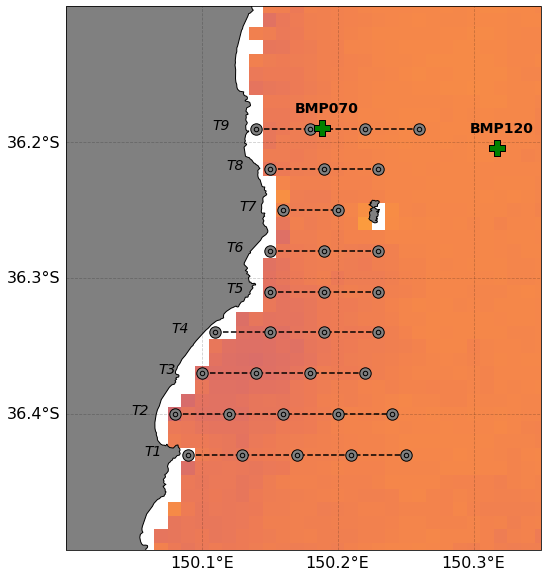

In [244]:
fig = plt.figure(figsize=(18,10))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())

#set coastline
feature = ax.add_feature(coast_shp, edgecolor='black',facecolor='gray')
im = modis.sst.plot.pcolormesh(cmap=cmocean.cm.thermal, add_colorbar=False,
                               vmin=7, vmax=25)#,vmin=16, vmax=22)
extent_ls = [150,150.35,-36.1,-36.5]
ax.set_extent(extent_ls)

# make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True, color='black',
                  alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.ylocator = mticker.FixedLocator([-36.2, -36.3, -36.4])
gl.xlocator = mticker.FixedLocator([150.1, 150.2, 150.3])

# SST label
#plt.text(extent_ls[0]+.01, extent_ls[2]-.03, 'SST ($^o$C)', size=14)
# Colorbar
# cax = inset_axes(ax,
#                  width="2.5%",  # % of parent_bbox width
#                  height="54%",
#                  loc='lower left',
#                  bbox_to_anchor=(.03,.35, 1, 1), #(lowleft x, lowleft y, ..dunno)
#                  bbox_transform=ax.transAxes,
#                  borderpad=0)
# fig.colorbar(im, cax=cax)#, format='%d')
# cax.tick_params(labelsize=14)

# Transects
for i, row in transects.iterrows():
    ax.plot([row.lon1, row.lon2], [row.lat1, row.lat2], c='black', linestyle="--", zorder=9)
    ax.text(row.lon1-.032, row.lat1, 'T'+str(round(row.transect)), size=14, fontweight='medium', fontstyle='italic', zorder=12)

# Survey stations
ax.scatter(stations.lon, stations.lat, s=130, c='grey', marker='o', edgecolors='black', zorder=10)
ax.scatter(stations.lon, stations.lat, s=20, c='grey', marker='o', edgecolors='black', zorder=10)

# Moorings
ax.scatter(moorings.lon, moorings.lat, s=250, c='green', marker='P', edgecolors='black', zorder=11)
for i, row in moorings.iterrows():
    ax.text(row.lon-.02, row.lat+.012, row.id, size=14, fontweight='bold', zorder=12)
    
plt.savefig("./figures/Map/update/right.png",
                    format="png",
                    bbox_inches='tight',
                    pad_inches=0.1, 
                    dpi=300)